# Classification methods and model evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('blood_transfusion.csv')

data.head()

,months_since_last_donation,total_number_of_donations,total_blood_donated,months_since_first_donation,class
0,2.0,50.0,12500.0,98.0,1
1,0.0,13.0,3250.0,28.0,1
2,1.0,16.0,4000.0,35.0,1
3,2.0,20.0,5000.0,45.0,1
4,1.0,24.0,6000.0,77.0,0


# 1. Get dataset on screen

In [2]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_since_last_donation   748 non-null    float64
 1   total_number_of_donations    748 non-null    float64
 2   total_blood_donated          748 non-null    float64
 3   months_since_first_donation  748 non-null    float64
 4   class                        748 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.3 KB


,months_since_last_donation,total_number_of_donations,total_blood_donated,months_since_first_donation,class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [3]:
class_counts = data['class'].value_counts()
print(f"\nClass 0 (Did NOT return): {class_counts[0]} ({class_counts[0]/len(data)*100:.1f}%)")
print(f"Class 1 (DID return): {class_counts[1]} ({class_counts[1]/len(data)*100:.1f}%)")

# Average donation patterns by class
print("\nAverage patterns by return status:")
for class_label in [0, 1]:
    class_name = "Returned" if class_label == 1 else "Did NOT return"
    subset = data[data['class'] == class_label]
    print(f"\n{class_name}:")
    print(f"  - Avg months since last donation: {subset['months_since_last_donation'].mean():.1f}")
    print(f"  - Avg total donations: {subset['total_number_of_donations'].mean():.1f}")
    print(f"  - Avg total blood donated (ml): {subset['total_blood_donated'].mean():.1f}")
    print(f"  - Avg months since first donation: {subset['months_since_first_donation'].mean():.1f}")

print("""
The blood center has {total} donors in their database, where only {pct}% return to donate in the following month.
Donors who return tend to have a higher total donations count and donated more blood overall.
This suggests that frequent donors are more likely to return. Understanding these patterns could help the center target and encourage more donations
""".format(total=len(data), pct=round(class_counts[1]/len(data)*100, 1)))


Class 0 (Did NOT return): 570 (76.2%)
Class 1 (DID return): 178 (23.8%)

Average patterns by return status:

Did NOT return:
  - Avg months since last donation: 10.8
  - Avg total donations: 4.8
  - Avg total blood donated (ml): 1200.4
  - Avg months since first donation: 34.8

Returned:
  - Avg months since last donation: 5.5
  - Avg total donations: 7.8
  - Avg total blood donated (ml): 1949.4
  - Avg months since first donation: 32.7

The blood center has 748 donors in their database, where only 23.8% return to donate in the following month.
Donors who return tend to have a higher total donations count and donated more blood overall.
This suggests that frequent donors are more likely to return. Understanding these patterns could help the center target and encourage more donations



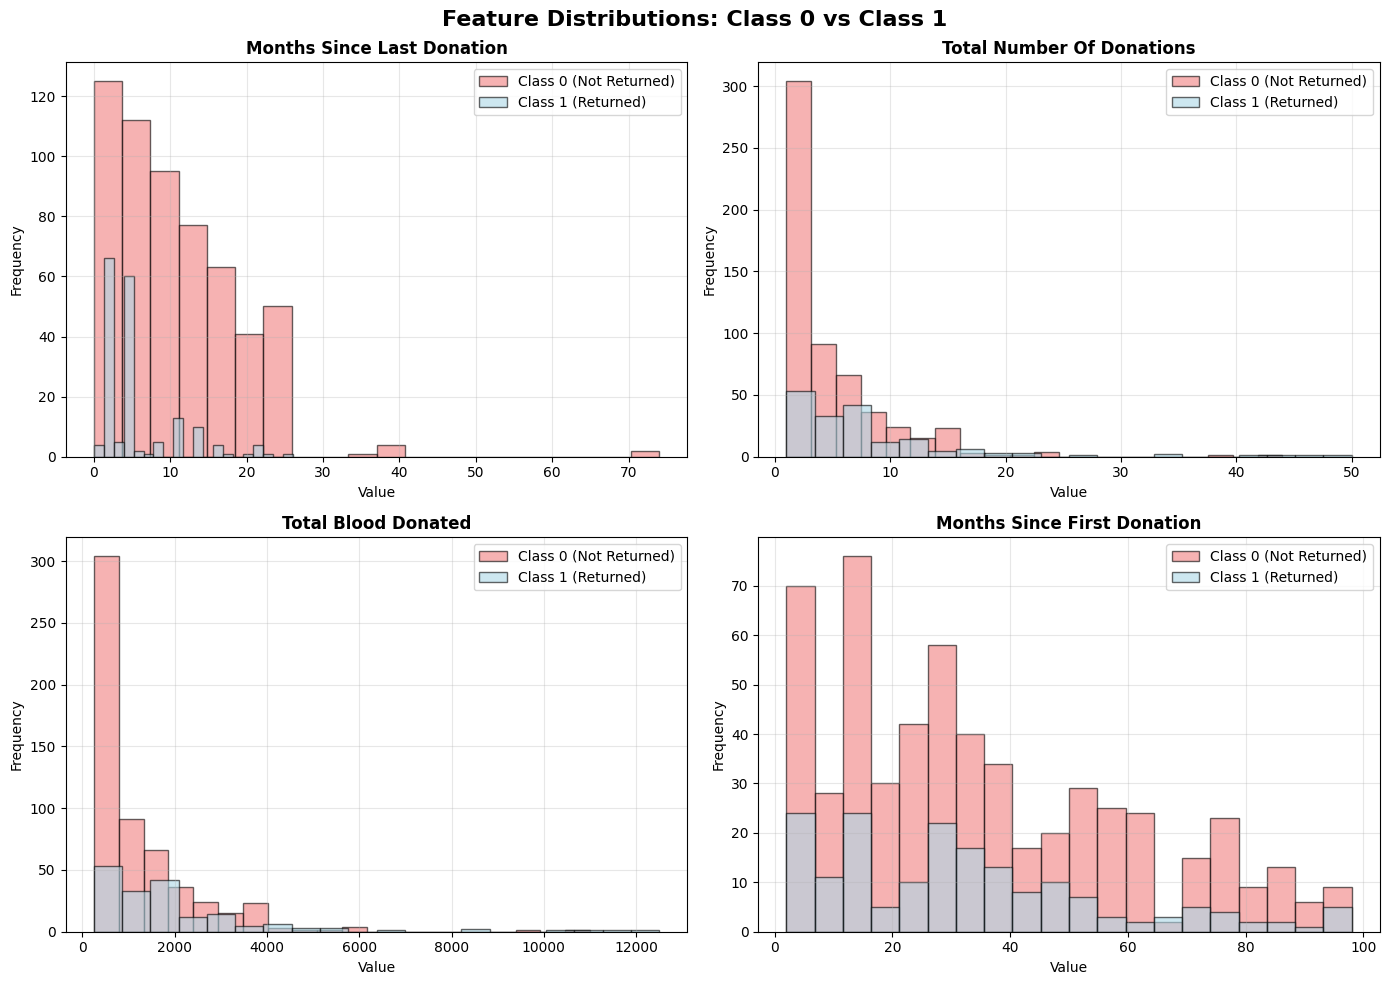

In [4]:
features = ['months_since_last_donation', 'total_number_of_donations', 
            'total_blood_donated', 'months_since_first_donation']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Distributions: Class 0 vs Class 1', 
             fontsize=16, fontweight='bold')

for idx, feature in enumerate(features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot histograms for both classes
    ax.hist(data[data['class'] == 0][feature], bins=20, alpha=0.6, 
            label='Class 0 (Not Returned)', color='lightcoral', edgecolor='black')
    ax.hist(data[data['class'] == 1][feature], bins=20, alpha=0.6, 
            label='Class 1 (Returned)', color='lightblue', edgecolor='black')
    
    ax.set_title(feature.replace('_', ' ').title(), fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Task 2: Preprocessing

In [5]:
from sklearn.preprocessing import RobustScaler

# create meaningful features
X_original = data.drop('class', axis=1).copy()
y = data['class']

# donation frequency - most predictive feature
X_original['donation_frequency'] = X_original['total_number_of_donations'] / (X_original['months_since_first_donation'] + 1)

# recency ratio
X_original['recency_ratio'] = X_original['months_since_last_donation'] / (X_original['months_since_first_donation'] + 1)

# avg time between donations
X_original['avg_interval'] = (X_original['months_since_first_donation'] - X_original['months_since_last_donation']) / (X_original['total_number_of_donations'] + 1)

# drop correlated feature
X = X_original.drop('total_blood_donated', axis=1)

print("Features after engineering:")
print(X.columns.tolist())
print(f"Shape: {X.shape}")

print("\nFeature correlations with target:")
for col in X.columns:
    corr = X[col].corr(data['class'])
    print(f"{col:30s}: {corr:.3f}")

Features after engineering:
['months_since_last_donation', 'total_number_of_donations', 'months_since_first_donation', 'donation_frequency', 'recency_ratio', 'avg_interval']
Shape: (748, 6)

Feature correlations with target:
months_since_last_donation    : -0.280
total_number_of_donations     : 0.219
months_since_first_donation   : -0.036
donation_frequency            : 0.315
recency_ratio                 : -0.222
avg_interval                  : -0.075


# Task 3: Creating a train and test set

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def create_splits(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=8, stratify=y
    )
    
    # scale with robust scaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # apply SMOTE to balance training set
    smote = SMOTE(random_state=8, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"Original train size: {len(y_train)}, After SMOTE: {len(y_train_balanced)}")
    print(f"Class distribution: {np.bincount(y_train_balanced)}")
    
    return X_train_balanced, X_test_scaled, y_train_balanced, y_test, scaler

# split 1: 80/20
X_train_1, X_test_1, y_train_1, y_test_1, scaler_1 = create_splits(X, y, test_size=0.2)
print(f"Split 1 - Test size: {len(X_test_1)}\n")

# split 2: 70/30
X_train_2, X_test_2, y_train_2, y_test_2, scaler_2 = create_splits(X, y, test_size=0.3)
print(f"Split 2 - Test size: {len(X_test_2)}")

Original train size: 598, After SMOTE: 912
Class distribution: [456 456]
Split 1 - Test size: 150

Original train size: 523, After SMOTE: 798
Class distribution: [399 399]
Split 2 - Test size: 225


# Task 4: Classification algorithms 

### Task 4.1 - KNN Classifier


In [7]:
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def knn_predict(X_train, y_train, X_test, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], X_test)
        distances.append((dist, y_train.iloc[i]))
    
    distances.sort(key=lambda x: x[0])
    k_nearest_labels = [label for _, label in distances[:k]]
    return Counter(k_nearest_labels).most_common(1)[0][0]

def knn_predict_all(X_train, y_train, X_test, k):
    y_pred = []
    for i in range(len(X_test)):
        y_pred.append(knn_predict(X_train, y_train, X_test[i], k))
    return np.array(y_pred)

k = 3

# split 1
y_pred_knn_1 = knn_predict_all(X_train_1, y_train_1, X_test_1, k)
print(f"KNN (k={k}) Split 1:")
print(f"  Predicted: {y_pred_knn_1[:10]}")
print(f"  Actual:    {y_test_1.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_1, y_pred_knn_1):.3f}")
print(f"  Recall: {recall_score(y_test_1, y_pred_knn_1):.3f}")

# split 2
y_pred_knn_2 = knn_predict_all(X_train_2, y_train_2, X_test_2, k)
print(f"\nKNN (k={k}) Split 2:")
print(f"  Predicted: {y_pred_knn_2[:10]}")
print(f"  Actual:    {y_test_2.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_2, y_pred_knn_2):.3f}")
print(f"  Recall: {recall_score(y_test_2, y_pred_knn_2):.3f}")

KNN (k=3) Split 1:
  Predicted: [1 1 0 0 0 1 0 0 1 0]
  Actual:    [1 1 1 0 0 0 1 0 0 0]
  Accuracy: 0.647
  Recall: 0.639

KNN (k=3) Split 2:
  Predicted: [0 0 1 0 1 1 1 1 1 0]
  Actual:    [0 0 1 1 0 1 0 0 0 0]
  Accuracy: 0.662
  Recall: 0.593


### Task 4.2 - Naive Bayes Classifier

In [8]:
from sklearn import naive_bayes

# split 1
gnb_1 = naive_bayes.GaussianNB(priors=[0.4, 0.6])
gnb_1.fit(X_train_1, y_train_1)
y_pred_gnb_1 = gnb_1.predict(X_test_1)

print("Naive Bayes (40/60 priors) Split 1:")
print(f"  Predicted: {y_pred_gnb_1[:10]}")
print(f"  Actual:    {y_test_1.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_1, y_pred_gnb_1):.3f}")
print(f"  Recall: {recall_score(y_test_1, y_pred_gnb_1):.3f}")

# split 2
gnb_2 = naive_bayes.GaussianNB(priors=[0.4, 0.6])
gnb_2.fit(X_train_2, y_train_2)
y_pred_gnb_2 = gnb_2.predict(X_test_2)

print("\nNaive Bayes (40/60 priors) Split 2:")
print(f"  Predicted: {y_pred_gnb_2[:10]}")
print(f"  Actual:    {y_test_2.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_2, y_pred_gnb_2):.3f}")
print(f"  Recall: {recall_score(y_test_2, y_pred_gnb_2):.3f}")

Naive Bayes (40/60 priors) Split 1:
  Predicted: [1 1 1 0 1 0 0 1 1 1]
  Actual:    [1 1 1 0 0 0 1 0 0 0]
  Accuracy: 0.627
  Recall: 0.833

Naive Bayes (40/60 priors) Split 2:
  Predicted: [0 0 1 1 0 1 0 1 1 0]
  Actual:    [0 0 1 1 0 1 0 0 0 0]
  Accuracy: 0.653
  Recall: 0.833


### Task 4.3 - Support Vector Classifier

In [9]:
from sklearn import svm

# split 1
svc_1 = svm.SVC(kernel='rbf', C=1.0, class_weight={0: 1, 1: 3}, random_state=8)
svc_1.fit(X_train_1, y_train_1)
y_pred_svm_1 = svc_1.predict(X_test_1)

print("SVM (C=1.0, weight 1:3) Split 1:")
print(f"  Predicted: {y_pred_svm_1[:10]}")
print(f"  Actual:    {y_test_1.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_1, y_pred_svm_1):.3f}")
print(f"  Recall: {recall_score(y_test_1, y_pred_svm_1):.3f}")

# split 2
svc_2 = svm.SVC(kernel='rbf', C=1.0, class_weight={0: 1, 1: 3}, random_state=8)
svc_2.fit(X_train_2, y_train_2)
y_pred_svm_2 = svc_2.predict(X_test_2)

print("\nSVM (C=1.0, weight 1:3) Split 2:")
print(f"  Predicted: {y_pred_svm_2[:10]}")
print(f"  Actual:    {y_test_2.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_2, y_pred_svm_2):.3f}")
print(f"  Recall: {recall_score(y_test_2, y_pred_svm_2):.3f}")

SVM (C=1.0, weight 1:3) Split 1:
  Predicted: [1 1 1 0 1 1 1 1 1 1]
  Actual:    [1 1 1 0 0 0 1 0 0 0]
  Accuracy: 0.427
  Recall: 0.889

SVM (C=1.0, weight 1:3) Split 2:
  Predicted: [0 1 1 1 1 1 1 1 1 0]
  Actual:    [0 0 1 1 0 1 0 0 0 0]
  Accuracy: 0.449
  Recall: 0.944


### Task 4.4 - Multilayer Perceptron (Neural Network)

In [10]:

from sklearn import neural_network

# split 1
mlp_1 = neural_network.MLPClassifier(
    hidden_layer_sizes=(10, 5),
    alpha=0.0001,
    max_iter=2000,
    random_state=8
)
mlp_1.fit(X_train_1, y_train_1)
y_pred_mlp_1 = mlp_1.predict(X_test_1)

print("MLP (10,5) Split 1:")
print(f"  Predicted: {y_pred_mlp_1[:10]}")
print(f"  Actual:    {y_test_1.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_1, y_pred_mlp_1):.3f}")
print(f"  Recall: {recall_score(y_test_1, y_pred_mlp_1):.3f}")

# split 2
mlp_2 = neural_network.MLPClassifier(
    hidden_layer_sizes=(10, 5),
    alpha=0.0001,
    max_iter=2000,
    random_state=8
)
mlp_2.fit(X_train_2, y_train_2)
y_pred_mlp_2 = mlp_2.predict(X_test_2)

print("\nMLP (10,5) Split 2:")
print(f"  Predicted: {y_pred_mlp_2[:10]}")
print(f"  Actual:    {y_test_2.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_2, y_pred_mlp_2):.3f}")
print(f"  Recall: {recall_score(y_test_2, y_pred_mlp_2):.3f}")

MLP (10,5) Split 1:
  Predicted: [1 1 1 0 1 0 0 0 1 0]
  Actual:    [1 1 1 0 0 0 1 0 0 0]
  Accuracy: 0.613
  Recall: 0.694

MLP (10,5) Split 2:
  Predicted: [0 0 1 1 0 1 1 1 0 0]
  Actual:    [0 0 1 1 0 1 0 0 0 0]
  Accuracy: 0.742
  Recall: 0.815


# Task 5: Evaluation of classification methods

### Task 5.1 - manual confusion matrix

In [11]:
def compute_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for true_val, pred_val in zip(y_true, y_pred):
        true_idx = np.where(classes == true_val)[0][0]
        pred_idx = np.where(classes == pred_val)[0][0]
        cm[true_idx][pred_idx] += 1
    
    return cm

models_split1 = {
    'KNN': y_pred_knn_1,
    'Naive Bayes': y_pred_gnb_1,
    'SVM': y_pred_svm_1,
    'MLP': y_pred_mlp_1
}

models_split2 = {
    'KNN': y_pred_knn_2,
    'Naive Bayes': y_pred_gnb_2,
    'SVM': y_pred_svm_2,
    'MLP': y_pred_mlp_2
}

print("Confusion Matrices - Split 1:")
for name, preds in models_split1.items():
    cm = compute_confusion_matrix(y_test_1.values, preds)
    print(f"\n{name}:")
    print(f"[[TN={cm[0,0]}, FP={cm[0,1]}],")
    print(f" [FN={cm[1,0]}, TP={cm[1,1]}]]")

print("\n\nConfusion Matrices - Split 2:")
for name, preds in models_split2.items():
    cm = compute_confusion_matrix(y_test_2.values, preds)
    print(f"\n{name}:")
    print(f"[[TN={cm[0,0]}, FP={cm[0,1]}],")
    print(f" [FN={cm[1,0]}, TP={cm[1,1]}]]")

Confusion Matrices - Split 1:

KNN:
[[TN=74, FP=40],
 [FN=13, TP=23]]

Naive Bayes:
[[TN=64, FP=50],
 [FN=6, TP=30]]

SVM:
[[TN=32, FP=82],
 [FN=4, TP=32]]

MLP:
[[TN=67, FP=47],
 [FN=11, TP=25]]


Confusion Matrices - Split 2:

KNN:
[[TN=117, FP=54],
 [FN=22, TP=32]]

Naive Bayes:
[[TN=102, FP=69],
 [FN=9, TP=45]]

SVM:
[[TN=50, FP=121],
 [FN=3, TP=51]]

MLP:
[[TN=123, FP=48],
 [FN=10, TP=44]]


### Task 5.2 - classification report

In [12]:
from sklearn.metrics import classification_report

print("Classification Reports - Split 1:")
for name, preds in models_split1.items():
    print(f"\n{name}:")
    print(classification_report(y_test_1, preds))

print("\n\nClassification Reports - Split 2:")
for name, preds in models_split2.items():
    print(f"\n{name}:")
    print(classification_report(y_test_2, preds))

Classification Reports - Split 1:

KNN:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       114
           1       0.37      0.64      0.46        36

    accuracy                           0.65       150
   macro avg       0.61      0.64      0.60       150
weighted avg       0.73      0.65      0.67       150


Naive Bayes:
              precision    recall  f1-score   support

           0       0.91      0.56      0.70       114
           1       0.38      0.83      0.52        36

    accuracy                           0.63       150
   macro avg       0.64      0.70      0.61       150
weighted avg       0.78      0.63      0.65       150


SVM:
              precision    recall  f1-score   support

           0       0.89      0.28      0.43       114
           1       0.28      0.89      0.43        36

    accuracy                           0.43       150
   macro avg       0.58      0.58      0.43       150
weighted avg  

### Task 5.3 - fbeta score

In [13]:
from sklearn.metrics import fbeta_score

beta = 2

print(f"F-beta (beta={beta}) Scores:")
print("\nSplit 1:")
for name, preds in models_split1.items():
    score = fbeta_score(y_test_1, preds, beta=beta)
    print(f"{name}: {score:.4f}")

print("\nSplit 2:")
for name, preds in models_split2.items():
    score = fbeta_score(y_test_2, preds, beta=beta)
    print(f"{name}: {score:.4f}")

F-beta (beta=2) Scores:

Split 1:
KNN: 0.5556
Naive Bayes: 0.6696
SVM: 0.6202
MLP: 0.5787

Split 2:
KNN: 0.5298
Naive Bayes: 0.6818
SVM: 0.6572
MLP: 0.7143


In [14]:
"""
Optimizing parameter for prior
"""
from sklearn.model_selection import KFold


split1_cv = [X_train_1, X_test_1, y_train_1, y_test_1, scaler_1]
split2_cv = [X_train_2, X_test_2, y_train_2, y_test_2, scaler_2]

splits_cv = [split1_cv,split2_cv]


for s in splits_cv:
    X_train_split, X_test_split = s[0], s[1]
    y_train_split, y_test_split = s[2], s[3]

    kf = KFold(n_splits = 5, shuffle = False)
    kf.get_n_splits(X_train_split)
    print(kf)

    metrics_per_prior = []

    priors = [[0.8,0.2],[0.7,0.3],[0.6,0.4],[0.5, 0.5],[0.4, 0.6],[0.3, 0.7],[0.2,0.8]]

    for p in priors:
        fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}


        for j, (train_index, val_index) in enumerate(kf.split(X_train_split)):
            X_train = X_train_split[train_index]
            X_val = X_train_split[val_index]
            y_train = y_train_split[train_index]
            y_val = y_train_split[val_index]
            
            gnb = naive_bayes.GaussianNB(priors=p)
            gnb.fit(X_train, y_train)
            y_pred = gnb.predict(X_val)

            #print(classification_report(y_val, y_pred, zero_division=0))
            fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
            fold_metrics['precision'].append(precision_score(y_val, y_pred, zero_division=0))
            fold_metrics['recall'].append(recall_score(y_val, y_pred, zero_division=0))
            fold_metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
            
        metrics_per_prior.append(fold_metrics)

    mean_accuracies = [np.mean(m['accuracy']) for m in metrics_per_prior]
    best_priors = priors[np.argmax(mean_accuracies)]
    print("Best priors:", best_priors)
    



KFold(n_splits=5, random_state=None, shuffle=False)
Best priors: [0.6, 0.4]
KFold(n_splits=5, random_state=None, shuffle=False)
Best priors: [0.6, 0.4]


In [15]:
"""
Classification reports for optimized prior by crossvalidation (Refitting the models with best parameters settings)
"""

gnb_1 = naive_bayes.GaussianNB(priors=[0.6, 0.4])
gnb_1.fit(X_train_1, y_train_1)
y_pred_gnb_1 = gnb_1.predict(X_test_1)
"""
print("Naive Bayes (60/40 priors) Split 1:")
print(f"  Predicted: {y_pred_gnb_1[:10]}")
print(f"  Actual:    {y_test_1.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_1, y_pred_gnb_1):.3f}")
print(f"  Recall: {recall_score(y_test_1, y_pred_gnb_1):.3f}")
"""
print("Classification Reports - Split 1:")
print(f"Split 1:")
print(classification_report(y_test_1, y_pred_gnb_1))

# split 2
gnb_2 = naive_bayes.GaussianNB(priors=[0.6, 0.4])
gnb_2.fit(X_train_2, y_train_2)
y_pred_gnb_2 = gnb_2.predict(X_test_2)

"""
print("\nNaive Bayes (60/40 priors) Split 2:")
print(f"  Predicted: {y_pred_gnb_2[:10]}")
print(f"  Actual:    {y_test_2.values[:10]}")
print(f"  Accuracy: {accuracy_score(y_test_2, y_pred_gnb_2):.3f}")
print(f"  Recall: {recall_score(y_test_2, y_pred_gnb_2):.3f}")
"""
print("Classification Reports - Split 2:")
print(f"Split 2:")
print(classification_report(y_test_2, y_pred_gnb_2))


Classification Reports - Split 1:
Split 1:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       114
           1       0.45      0.81      0.57        36

    accuracy                           0.71       150
   macro avg       0.68      0.74      0.68       150
weighted avg       0.80      0.71      0.73       150

Classification Reports - Split 2:
Split 2:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       171
           1       0.46      0.78      0.58        54

    accuracy                           0.72       225
   macro avg       0.68      0.74      0.69       225
weighted avg       0.80      0.72      0.74       225



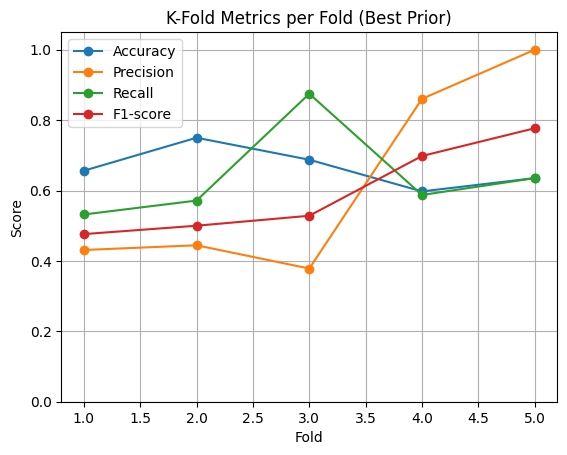

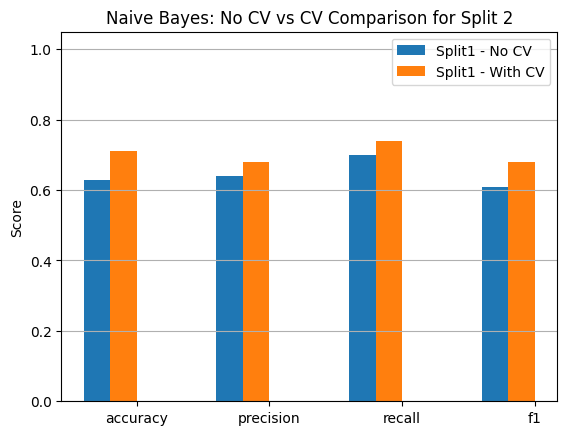

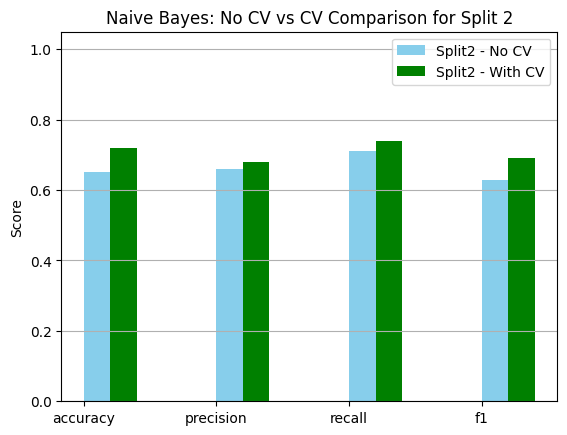

In [16]:
"""
Plots for presentation
"""

best_index = np.argmax(mean_accuracies)
best_metrics = metrics_per_prior[best_index]

folds = range(1, kf.get_n_splits(X_train_split)+1)

plt.plot(folds, best_metrics['accuracy'], marker='o', label='Accuracy')
plt.plot(folds, best_metrics['precision'], marker='o', label='Precision')
plt.plot(folds, best_metrics['recall'], marker='o', label='Recall')
plt.plot(folds, best_metrics['f1'], marker='o', label='F1-score')
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("K-Fold Metrics per Fold (Best Prior)")
plt.ylim(0,1.05)
plt.grid(True)
plt.legend()
plt.show()

# macro avg values
baseline_split1 = {'accuracy': 0.63, 'precision': 0.64, 'recall': 0.70, 'f1': 0.61}
baseline_split2 = {'accuracy': 0.65, 'precision': 0.66, 'recall': 0.71, 'f1': 0.63}

cv_split1 = {'accuracy': 0.71, 'precision': 0.68, 'recall': 0.74, 'f1': 0.68}
cv_split2 = {'accuracy': 0.72, 'precision': 0.68, 'recall': 0.74, 'f1': 0.69}

metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics))
width = 0.2

plt.bar(x - width, [baseline_split1[m] for m in metrics], width, label='Split1 - No CV')
plt.bar(x, [cv_split1[m] for m in metrics], width, label='Split1 - With CV')
plt.xticks(x + width/2, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Naive Bayes: No CV vs CV Comparison for Split 2")
plt.legend()
plt.grid(axis='y')
plt.show()


plt.bar(x + width, [baseline_split2[m] for m in metrics], width, label='Split2 - No CV', color = 'skyblue')
plt.bar(x + 2*width, [cv_split2[m] for m in metrics], width, label='Split2 - With CV', color = 'green')
plt.xticks(x + width/2, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Naive Bayes: No CV vs CV Comparison for Split 2")
plt.legend()
plt.grid(axis='y')
plt.show()

